In [4]:
from derive_conceptualspace.evaluate.shallow_trees import classify_shallowtree
from derive_conceptualspace.pipeline import SnakeContext, load_envfiles
from derive_conceptualspace.util.result_analysis_tools import get_best_conf, highlight_nonzero_max, highlight_max
from derive_conceptualspace.cli.args_from_filename import get_filename, print_envvars
from misc_util.logutils import setup_logging

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Let's first create a quick table of the best configs

In [102]:
import pandas as pd
import numpy as np
import pyperclip
from derive_conceptualspace.util.result_analysis_tools import df_to_latex, shorten_met
from derive_conceptualspace.util.desc_object import DescriptionList
from derive_conceptualspace.pipeline import cluster_loader
from joblib import parallel_backend
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import Markdown
flatten = lambda l: [item for sublist in l for item in sublist] 

In [3]:
setup_logging()
load_envfiles("siddata")

In [3]:
conf_results = get_best_conf("fachbereich", verbose=False, balance_classes=True, 
                             one_vs_rest=True, dt_depth=1, test_percentage_crossval=0.3, return_all=True, nprocs=5)

Getting Best-Performing Config [5 procs]:   0%|          | 0/165 [00:00<?, ?it/s]

In [25]:
styles = [{'selector': 'th', 'props': [('vertical-align','top'),('text-align','left')]}]  #('border-style', 'solid')
styler = lambda df: df.style.format('{:.2%}'.format, na_rep="-").format_index(precision=1,axis=1).set_table_styles(styles) #{"amax": '{:.0%}'.format, "mean": '{:.2%}'.format}
pd.set_option("display.precision", 4)

df = conf_results.T.unstack(level=["classifier_succmetric", "embed_dimensions", "sec_lambda"])
df.index = pd.MultiIndex.from_arrays(list(zip(*[[shorten_met(j) for j in i] for i in df.index])), names=df.index.names)
df.columns = pd.MultiIndex.from_arrays(list(zip(*[[shorten_met(j) for j in i] for i in df.columns])), names=df.columns.names)

display(styler(df).apply(highlight_max, axis=None))

pyperclip.copy(df_to_latex(df, styler, rotate=False, caption="Decision-Tree-Accuracies for different Parameter-Combinations"))

In [30]:
print(df_to_latex(df, styler, rotate=False, caption="Decision-Tree-Accuracies for different Parameter-Combinations"))

\begin{table}
\resizebox{\textwidth}{!}{\%
\caption{Decision-Tree-Accuracies for different Parameter-Combinations}
\begin{tabular}{lllrrrrrrrrrrrrrrrrrr}
\toprule
 &  &  & \textbf{k_c2r+} & \textbf{k_c2r+} & \textbf{k_dig+_2} & \textbf{k_dig+_2} & \textbf{k_r2r+_min} & \textbf{k_r2r+_min} & \textbf{k_c2r+} & \textbf{k_c2r+} & \textbf{k_dig+_2} & \textbf{k_dig+_2} & \textbf{k_r2r+_min} & \textbf{k_r2r+_min} & \textbf{k_c2r+} & \textbf{k_c2r+} & \textbf{k_dig+_2} & \textbf{k_dig+_2} & \textbf{k_r2r+_min} & \textbf{k_r2r+_min} \\
\textbf{pp_components} & \textbf{quantification_measure} & \textbf{dcm_quant_measure} &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{6}{*}{\textbf{mfauhcsd2}} & \multirow[t]{3}{*}{\textbf{ppmi}} & \textbf{count} & 55.02\% & 48.09\% & 50.57\% & 58.31\% & 62.21\% & 67.31\% & 42.53\% & 35.55\% & 75.87\% & 75.43\% & 75.34\% & 74.40\% & 42.11\% & 44.69\% & 79.74\% & 77.13\% & 69.86\% & 75.05\% \\
 &  & \textbf{ppmi} & - & - & 65.31\% & 

## Next: Robust accuracies for different depths

In [5]:
# best_conf = {k: str(v) for k, v in dict(zip(conf_results.columns.names, conf_results.T.idxmax()[0])).items()}
best_conf = {'pp_components': 'mfauhcsd2', 'quantification_measure': 'tfidf', 'embed_dimensions': '200', 'dcm_quant_measure': 'count', 'classifier_succmetric': 'kappa_digitized_onlypos_2', 'sec_lambda': '0.2'}
print("Best conf:", best_conf)

ctx = SnakeContext.loader_context(config={**best_conf, "debug": False}, silent=True)
ctx.print_important_settings()
descriptions, clusters, embedding = ctx.load("pp_descriptions", "clusters", "embedding", 
                  loaders=dict(pp_descriptions=DescriptionList.from_json, clusters=cluster_loader, embedding=lambda **args: args["embedding"].embedding_))

Best conf: {'pp_components': 'mfauhcsd2', 'quantification_measure': 'tfidf', 'embed_dimensions': '200', 'dcm_quant_measure': 'count', 'classifier_succmetric': 'kappa_digitized_onlypos_2', 'sec_lambda': '0.2'}


<span style="font-size:11pt">Running with the following settings [<span style="color: #ff00ff">4a341d441d</span>]: CLASSIFIER: <span style="color: #0000ff">SVM</span>, CLASSIFIER_SUCCMETRIC: <span style="color: #ff0000">kappa_digitized_onlypos_2</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #0000ff">count</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">200</span>, EXTRACTION_METHOD: <span style="color: #ff0000">tfidf</span>, KAPPA_WEIGHTS: <span style="color: #0000ff">quadratic</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, PRIM_LAMBDA: <span style="color: #0000ff">0.5</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">tfidf</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, SEC_LAMBDA: <span style="color: #ff0000">0.2</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

In [201]:
metrics = ["accuracy", "f1"]
all_scores = {}
for depth in [1, 2, 3, None]:
    with parallel_backend('threading', n_jobs=7):
        scores, clsizes = classify_shallowtree(clusters, embedding, descriptions, ctx.obj["dataset_class"], one_vs_rest=True,
                                               classes="fachbereich", dt_depth=depth, test_percentage_crossval=5, metric=metrics, repeat=10, pgbar=True)
        scores = dict(sorted(scores.items(), key=lambda x: list(ctx.obj["dataset_class"].FB_MAPPER.values()).index(x[0])))
    for m in metrics:
        all_scores.setdefault(depth, {})[m] = {k: np.array(flatten([i[f"test_{m}"] for i in v])) for k, v in scores.items()}

<span style="font-size:11pt">Using classes from fachbereich - 7081/11601 entities have a class</span>

<span style="font-size:11pt">Labels (10 classes): <span style="color: #0000ff">Sprach-/Literaturwissenschaften</span>: 1659, <span style="color: #0000ff">Erziehungs-/Kulturwissenschaften</span>: 1998, <span style="color: #0000ff">Kultur-/Geowissenschaften</span>: 1447, <span style="color: #0000ff">Sozialwissenschaften</span>: 715, <span style="color: #0000ff">Rechtswissenschaften</span>: 334, <span style="color: #0000ff">Humanwissenschaften</span>: 354, <span style="color: #0000ff">Biologie/Chemie</span>: 160, <span style="color: #0000ff">Mathematik/Informatik</span>: 180, <span style="color: #0000ff">Physik</span>: 134, <span style="color: #0000ff">Wirtschaftswissenschaften</span>: 100</span>

<span style="font-size:11pt">Eval-Settings: metric: <span style="color: #0000ff">['accuracy', 'f1']</span>, type: <span style="color: #0000ff">one-vs-rest</span>, DT-Depth: <span style="color: #0000ff">1</span>, train-test-split:<span style="color: #0000ff"> 5-fold cross-validation </span></span>

100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


<span style="font-size:11pt">Using classes from fachbereich - 7081/11601 entities have a class</span>

<span style="font-size:11pt">Labels (10 classes): <span style="color: #0000ff">Sprach-/Literaturwissenschaften</span>: 1659, <span style="color: #0000ff">Erziehungs-/Kulturwissenschaften</span>: 1998, <span style="color: #0000ff">Kultur-/Geowissenschaften</span>: 1447, <span style="color: #0000ff">Sozialwissenschaften</span>: 715, <span style="color: #0000ff">Rechtswissenschaften</span>: 334, <span style="color: #0000ff">Humanwissenschaften</span>: 354, <span style="color: #0000ff">Biologie/Chemie</span>: 160, <span style="color: #0000ff">Mathematik/Informatik</span>: 180, <span style="color: #0000ff">Physik</span>: 134, <span style="color: #0000ff">Wirtschaftswissenschaften</span>: 100</span>

<span style="font-size:11pt">Eval-Settings: metric: <span style="color: #0000ff">['accuracy', 'f1']</span>, type: <span style="color: #0000ff">one-vs-rest</span>, DT-Depth: <span style="color: #0000ff">2</span>, train-test-split:<span style="color: #0000ff"> 5-fold cross-validation </span></span>

100%|██████████| 100/100 [01:57<00:00,  1.18s/it]


<span style="font-size:11pt">Using classes from fachbereich - 7081/11601 entities have a class</span>

<span style="font-size:11pt">Labels (10 classes): <span style="color: #0000ff">Sprach-/Literaturwissenschaften</span>: 1659, <span style="color: #0000ff">Erziehungs-/Kulturwissenschaften</span>: 1998, <span style="color: #0000ff">Kultur-/Geowissenschaften</span>: 1447, <span style="color: #0000ff">Sozialwissenschaften</span>: 715, <span style="color: #0000ff">Rechtswissenschaften</span>: 334, <span style="color: #0000ff">Humanwissenschaften</span>: 354, <span style="color: #0000ff">Biologie/Chemie</span>: 160, <span style="color: #0000ff">Mathematik/Informatik</span>: 180, <span style="color: #0000ff">Physik</span>: 134, <span style="color: #0000ff">Wirtschaftswissenschaften</span>: 100</span>

<span style="font-size:11pt">Eval-Settings: metric: <span style="color: #0000ff">['accuracy', 'f1']</span>, type: <span style="color: #0000ff">one-vs-rest</span>, DT-Depth: <span style="color: #0000ff">3</span>, train-test-split:<span style="color: #0000ff"> 5-fold cross-validation </span></span>

100%|██████████| 100/100 [03:06<00:00,  1.86s/it]


<span style="font-size:11pt">Using classes from fachbereich - 7081/11601 entities have a class</span>

<span style="font-size:11pt">Labels (10 classes): <span style="color: #0000ff">Sprach-/Literaturwissenschaften</span>: 1659, <span style="color: #0000ff">Erziehungs-/Kulturwissenschaften</span>: 1998, <span style="color: #0000ff">Kultur-/Geowissenschaften</span>: 1447, <span style="color: #0000ff">Sozialwissenschaften</span>: 715, <span style="color: #0000ff">Rechtswissenschaften</span>: 334, <span style="color: #0000ff">Humanwissenschaften</span>: 354, <span style="color: #0000ff">Biologie/Chemie</span>: 160, <span style="color: #0000ff">Mathematik/Informatik</span>: 180, <span style="color: #0000ff">Physik</span>: 134, <span style="color: #0000ff">Wirtschaftswissenschaften</span>: 100</span>

<span style="font-size:11pt">Eval-Settings: metric: <span style="color: #0000ff">['accuracy', 'f1']</span>, type: <span style="color: #0000ff">one-vs-rest</span>, DT-Depth: <span style="color: #0000ff">None</span>, train-test-split:<span style="color: #0000ff"> 5-fold cross-validation </span></span>

100%|██████████| 100/100 [13:14<00:00,  7.94s/it]


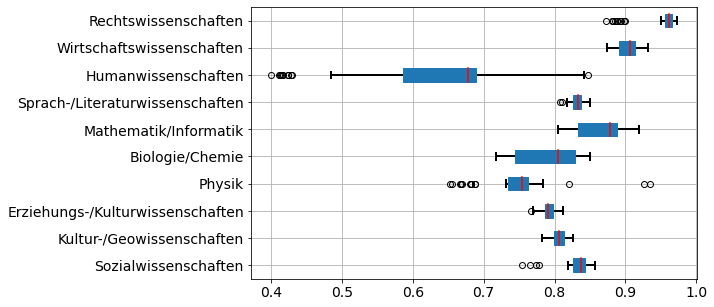

In [289]:
res = pd.DataFrame(all_scores[1]["accuracy"])
fig, ax = plt.subplots(figsize = [8, 5])
res.boxplot(ax=ax, vert=False, fontsize=14, patch_artist=True, medianprops=dict(color="red", linewidth=1.5), whiskerprops = dict(linestyle='-',linewidth=2.0), capprops=dict(linewidth=2.0));

with PdfPages("/home/chris/Documents/UNI_neu/Masterarbeit/MastersThesisText/graphics/dataset_new/accuracy_boxplots.pdf") as pdf:
    plt.show()
    pdf.savefig(fig, bbox_inches='tight')

In [293]:
res = pd.concat([pd.DataFrame(pd.DataFrame(all_scores[depth][metric]).unstack(), columns=pd.MultiIndex.from_product([[depth], [metric]], names=["depth","metric"])).T for depth, v in all_scores.items() for metric, v2 in v.items()])
res

Sozialwissenschaften                                          \
                                 0         1         2         3         4    
depth metric                                                                  
1.0   accuracy             0.832745  0.774011  0.836864  0.825565  0.842514   
      f1                   0.384416  0.365079  0.356546  0.384040  0.385675   
2.0   accuracy             0.812985  0.798023  0.859463  0.860876  0.814972   
      f1                   0.420131  0.383621  0.451791  0.469003  0.432900   
3.0   accuracy             0.717713  0.752119  0.822740  0.766243  0.781073   
      f1                   0.356913  0.393782  0.443459  0.369524  0.412879   
NaN   accuracy             0.908963  0.922316  0.918785  0.918079  0.915254   
      f1                   0.527473  0.598540  0.569288  0.582734  0.577465   

                                                                  ...  \
                      5         6         7         8         9   ...   
depth metric                                                      ...   
1.0   accuracy  0.857445  0.765537  0.839689  0.826977  0.840395  ...   
      f1        0.451087  0.325203  0.356941  0.370180  0.398936  ...   
2.0   accuracy  0.798871  0.814972  0.828390  0.834040  0.828390  ...   
      f1        0.402516  0.425439  0.443936  0.436451  0.414458  ...   
3.0   accuracy  0.771348  0.747175  0.800141  0.845339  0.770480  ...   
      f1        0.406593  0.374126  0.411642  0.431169  0.410163  ...   
NaN   accuracy  0.918843  0.919492  0.914548  0.913136  0.914548  ...   
      f1        0.593640  0.554688  0.575439  0.588629  0.566308  ...   

               Rechtswissenschaften                                          \
                                 40        41        42        43        44   
depth metric                                                                  
1.0   accuracy             0.963303  0.956921  0.956921  0.966808  0.882768   
      f1                   0.670886  0.625767  0.634731  0.700637  0.389706   
2.0   accuracy             0.896965  0.891243  0.885593  0.888418  0.890537   
      f1                   0.463235  0.446043  0.445205  0.435714  0.452297   
3.0   accuracy             0.968243  0.949859  0.934322  0.939972  0.957627   
      f1                   0.733728  0.612022  0.563380  0.597156  0.673913   
NaN   accuracy             0.987297  0.984463  0.990819  0.980226  0.986582   
      f1                   0.869565  0.833333  0.896000  0.774194  0.850394   

                                                                  
                      45        46        47        48        49  
depth metric                                                      
1.0   accuracy  0.964714  0.888418  0.956215  0.960452  0.968220  
      f1        0.675325  0.423358  0.626506  0.658537  0.689655  
2.0   accuracy  0.913903  0.890537  0.888418  0.924435  0.884887  
      f1        0.508065  0.444444  0.447552  0.524444  0.432056  
3.0   accuracy  0.923077  0.946328  0.966102  0.956215  0.937147  
      f1        0.532189  0.608247  0.720930  0.643678  0.586047  
NaN   accuracy  0.987297  0.985876  0.990113  0.986582  0.984463  
      f1        0.863636  0.855072  0.897059  0.850394  0.830769  

[8 rows x 500 columns]

### accuracy

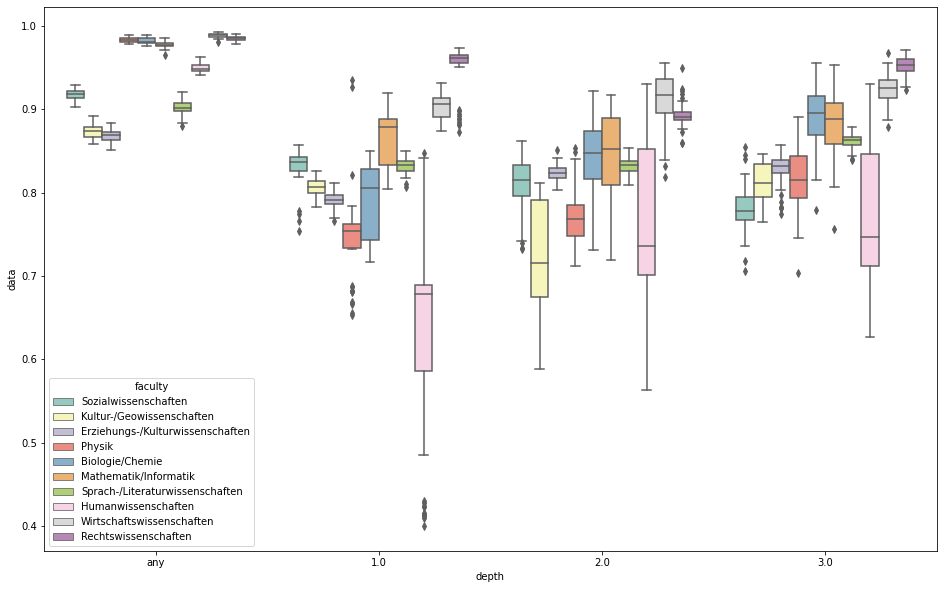

### f1

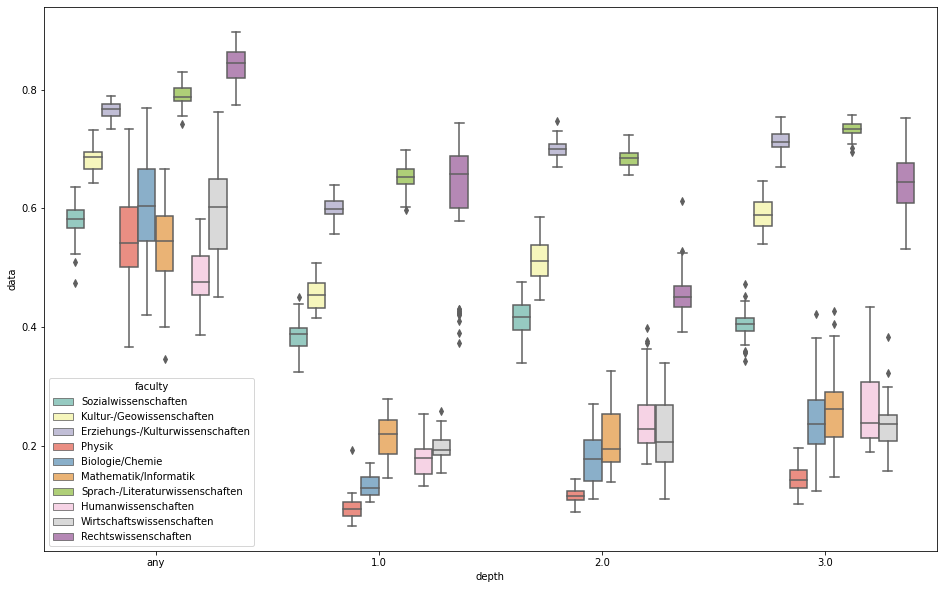

In [334]:
import seaborn as sns
# r2 = res.stack(level=0).reset_index().rename(columns={"level_2": "faculty"})
r2 = res.unstack(level=[0,1]).reset_index(level=1, drop=True).reset_index(name='data').rename(columns={"level_0": "faculty"})
r2["depth"] = r2["depth"].fillna("any")

for metric in r2["metric"].unique():
    fig, ax = plt.subplots(figsize = [16, 10])
    display(Markdown(f"### {metric}"))
    ax = sns.boxplot(x='depth', y='data', hue="faculty", data=r2[r2["metric"] == metric], palette="Set3", ax=ax)
    plt.show()

In [203]:
styles = [{'selector': 'th', 'props': [('vertical-align','top'),('text-align','left')]}] #('border-style', 'solid')  #see https://stackoverflow.com/a/55904239/5122790
styler = lambda df: df.style.format('{:.3f}'.format, na_rep="-").set_table_styles(styles)

summarized = {}
for depth, v in all_scores.items():
    for metric, scores in v.items():
        scores_df = pd.concat([pd.DataFrame(scores).agg((min, np.mean, max, np.std), axis="rows"), pd.DataFrame(clsizes, index=["samples"])])
        scores_df["unweighted_mean"] = scores_df.loc[["min", "mean", "max", "std"]].mean(axis=1)
        scores_df["weighted_mean"] = (scores_df.loc[["min", "mean", "max", "std"]] * scores_df.loc["samples"] / scores_df.loc["samples"].sum()).sum(axis=1)
        scores_df.loc["samples", ["unweighted_mean", "weighted_mean"]] = scores_df.loc["samples"].sum()
#         display(Markdown(f"### depth {depth}, metric {metric}"))
#         display(styler(scores_df.T))
        summarized[(depth, metric)] = scores_df.loc[["mean", "std"], :]

In [353]:
summarized_all = pd.DataFrame({smkey: {i[0]: f"{i[1]['mean']:.3f} ± {i[1]['std']:.3f}" for i in sm.T.iterrows()} for smkey, sm in summarized.items()})
# display(summarized_all)
style = [{'selector': 'th', 'props': [('text-align','center')]}]

for metric in ["accuracy", "f1"]:
    display(Markdown(f"## {metric}"))
    df = summarized_all.T.xs(metric, level=1).T
    df.columns = [int(i) if isinstance(i,float) else i for i in df.columns.fillna("any")]
    pyperclip.copy(df.style.set_table_styles(style).to_latex(convert_css=True, clines="skip-last;index", multirow_align="t", hrules=True, siunitx=False))
    display(df)

## accuracy

,1,2,3,any
Sozialwissenschaften,0.831 ± 0.021,0.811 ± 0.033,0.780 ± 0.028,0.918 ± 0.006
Kultur-/Geowissenschaften,0.806 ± 0.010,0.728 ± 0.066,0.813 ± 0.022,0.873 ± 0.008
Erziehungs-/Kulturwissenschaften,0.791 ± 0.010,0.824 ± 0.010,0.828 ± 0.020,0.868 ± 0.008
Physik,0.747 ± 0.054,0.770 ± 0.033,0.818 ± 0.038,0.983 ± 0.003
Biologie/Chemie,0.787 ± 0.044,0.838 ± 0.049,0.890 ± 0.036,0.982 ± 0.004
Mathematik/Informatik,0.866 ± 0.031,0.844 ± 0.051,0.882 ± 0.038,0.978 ± 0.004
Sprach-/Literaturwissenschaften,0.832 ± 0.009,0.832 ± 0.009,0.862 ± 0.009,0.902 ± 0.008
Humanwissenschaften,0.630 ± 0.130,0.768 ± 0.103,0.781 ± 0.093,0.949 ± 0.005
Wirtschaftswissenschaften,0.903 ± 0.015,0.910 ± 0.034,0.924 ± 0.018,0.989 ± 0.003
Rechtswissenschaften,0.948 ± 0.031,0.894 ± 0.015,0.952 ± 0.011,0.985 ± 0.003


## f1

,1,2,3,any
Sozialwissenschaften,0.386 ± 0.029,0.414 ± 0.031,0.403 ± 0.024,0.580 ± 0.034
Kultur-/Geowissenschaften,0.454 ± 0.023,0.514 ± 0.034,0.591 ± 0.026,0.685 ± 0.020
Erziehungs-/Kulturwissenschaften,0.600 ± 0.019,0.701 ± 0.015,0.713 ± 0.019,0.765 ± 0.015
Physik,0.096 ± 0.019,0.117 ± 0.012,0.145 ± 0.023,0.552 ± 0.072
Biologie/Chemie,0.133 ± 0.019,0.178 ± 0.043,0.247 ± 0.063,0.611 ± 0.084
Mathematik/Informatik,0.215 ± 0.032,0.211 ± 0.046,0.260 ± 0.057,0.542 ± 0.070
Sprach-/Literaturwissenschaften,0.652 ± 0.020,0.685 ± 0.014,0.733 ± 0.014,0.790 ± 0.017
Humanwissenschaften,0.177 ± 0.028,0.245 ± 0.061,0.276 ± 0.078,0.484 ± 0.043
Wirtschaftswissenschaften,0.198 ± 0.022,0.219 ± 0.059,0.236 ± 0.040,0.596 ± 0.084
Rechtswissenschaften,0.617 ± 0.108,0.456 ± 0.037,0.641 ± 0.050,0.841 ± 0.032


## What about not 1-vs-rest?

In [8]:
metrics = ["accuracy", "f1_macro"]
new_scores = {}
for depth in [1, 2, 3, None]:
    with parallel_backend('threading', n_jobs=7):
        scores, clsizes = classify_shallowtree(clusters, embedding, descriptions, ctx.obj["dataset_class"], one_vs_rest=False,
                                               classes="fachbereich", dt_depth=depth, test_percentage_crossval=5, metric=metrics, repeat=10, pgbar=True)
    for m in metrics:
        new_scores.setdefault(depth, {})[m] = np.array(flatten([i[f"test_{m}"] for i in scores]))

<span style="font-size:11pt">Using classes from fachbereich - 7081/11601 entities have a class</span>

<span style="font-size:11pt">Labels (10 classes): <span style="color: #0000ff">Sprach-/Literaturwissenschaften</span>: 1654, <span style="color: #0000ff">Erziehungs-/Kulturwissenschaften</span>: 2018, <span style="color: #0000ff">Kultur-/Geowissenschaften</span>: 1428, <span style="color: #0000ff">Sozialwissenschaften</span>: 702, <span style="color: #0000ff">Rechtswissenschaften</span>: 333, <span style="color: #0000ff">Humanwissenschaften</span>: 356, <span style="color: #0000ff">Biologie/Chemie</span>: 162, <span style="color: #0000ff">Mathematik/Informatik</span>: 186, <span style="color: #0000ff">Physik</span>: 137, <span style="color: #0000ff">Wirtschaftswissenschaften</span>: 105</span>

<span style="font-size:11pt">Eval-Settings: metric: <span style="color: #0000ff">['accuracy', 'f1_macro']</span>, type: <span style="color: #0000ff">all-at-once</span>, DT-Depth: <span style="color: #0000ff">1</span>, train-test-split:<span style="color: #0000ff"> 5-fold cross-validation </span></span>

derive_conceptualspace/evaluate/shallow_trees.py:140: UserWarning: There are more classes (10) than your decision-tree can possibly classify (2)


<span style="font-size:11pt">Using classes from fachbereich - 7081/11601 entities have a class</span>

<span style="font-size:11pt">Labels (10 classes): <span style="color: #0000ff">Sprach-/Literaturwissenschaften</span>: 1654, <span style="color: #0000ff">Erziehungs-/Kulturwissenschaften</span>: 2018, <span style="color: #0000ff">Kultur-/Geowissenschaften</span>: 1428, <span style="color: #0000ff">Sozialwissenschaften</span>: 702, <span style="color: #0000ff">Rechtswissenschaften</span>: 333, <span style="color: #0000ff">Humanwissenschaften</span>: 356, <span style="color: #0000ff">Biologie/Chemie</span>: 162, <span style="color: #0000ff">Mathematik/Informatik</span>: 186, <span style="color: #0000ff">Physik</span>: 137, <span style="color: #0000ff">Wirtschaftswissenschaften</span>: 105</span>

<span style="font-size:11pt">Eval-Settings: metric: <span style="color: #0000ff">['accuracy', 'f1_macro']</span>, type: <span style="color: #0000ff">all-at-once</span>, DT-Depth: <span style="color: #0000ff">2</span>, train-test-split:<span style="color: #0000ff"> 5-fold cross-validation </span></span>

derive_conceptualspace/evaluate/shallow_trees.py:140: UserWarning: There are more classes (10) than your decision-tree can possibly classify (4)


<span style="font-size:11pt">Using classes from fachbereich - 7081/11601 entities have a class</span>

<span style="font-size:11pt">Labels (10 classes): <span style="color: #0000ff">Sprach-/Literaturwissenschaften</span>: 1654, <span style="color: #0000ff">Erziehungs-/Kulturwissenschaften</span>: 2018, <span style="color: #0000ff">Kultur-/Geowissenschaften</span>: 1428, <span style="color: #0000ff">Sozialwissenschaften</span>: 702, <span style="color: #0000ff">Rechtswissenschaften</span>: 333, <span style="color: #0000ff">Humanwissenschaften</span>: 356, <span style="color: #0000ff">Biologie/Chemie</span>: 162, <span style="color: #0000ff">Mathematik/Informatik</span>: 186, <span style="color: #0000ff">Physik</span>: 137, <span style="color: #0000ff">Wirtschaftswissenschaften</span>: 105</span>

<span style="font-size:11pt">Eval-Settings: metric: <span style="color: #0000ff">['accuracy', 'f1_macro']</span>, type: <span style="color: #0000ff">all-at-once</span>, DT-Depth: <span style="color: #0000ff">3</span>, train-test-split:<span style="color: #0000ff"> 5-fold cross-validation </span></span>

derive_conceptualspace/evaluate/shallow_trees.py:140: UserWarning: There are more classes (10) than your decision-tree can possibly classify (8)


<span style="font-size:11pt">Using classes from fachbereich - 7081/11601 entities have a class</span>

<span style="font-size:11pt">Labels (10 classes): <span style="color: #0000ff">Sprach-/Literaturwissenschaften</span>: 1654, <span style="color: #0000ff">Erziehungs-/Kulturwissenschaften</span>: 2018, <span style="color: #0000ff">Kultur-/Geowissenschaften</span>: 1428, <span style="color: #0000ff">Sozialwissenschaften</span>: 702, <span style="color: #0000ff">Rechtswissenschaften</span>: 333, <span style="color: #0000ff">Humanwissenschaften</span>: 356, <span style="color: #0000ff">Biologie/Chemie</span>: 162, <span style="color: #0000ff">Mathematik/Informatik</span>: 186, <span style="color: #0000ff">Physik</span>: 137, <span style="color: #0000ff">Wirtschaftswissenschaften</span>: 105</span>

<span style="font-size:11pt">Eval-Settings: metric: <span style="color: #0000ff">['accuracy', 'f1_macro']</span>, type: <span style="color: #0000ff">all-at-once</span>, DT-Depth: <span style="color: #0000ff">None</span>, train-test-split:<span style="color: #0000ff"> 5-fold cross-validation </span></span>

In [9]:
df = pd.concat([pd.DataFrame(pd.DataFrame(new_scores[depth][metric]).unstack(), columns=pd.MultiIndex.from_product([[depth], [metric]], names=["depth","metric"])).T for depth, v in new_scores.items() for metric, v2 in v.items()])
df.index = pd.MultiIndex.from_tuples([(1, 'Accuracy'), (1, 'F1'), (2, 'Accuracy'), (2, 'F1'), (3, 'Accuracy'), (3, 'F1'), ("any", 'Accuracy'), ("any", 'F1')], names=['depth', 'metric'])
df = pd.DataFrame({i[0] if not pd.isna(i[0]) else "any": f"{i[1].mean():.3f} ± {i[1].std():.3f}" for i in df.iterrows()}, index=[""]).stack()
pyperclip.copy(df.style.to_latex(convert_css=True, multirow_align="t", hrules=True, siunitx=False))
df

1              2              3            any
 Accuracy  0.056 ± 0.008  0.078 ± 0.042  0.196 ± 0.017  0.584 ± 0.015
 F1        0.072 ± 0.006  0.125 ± 0.014  0.199 ± 0.007  0.513 ± 0.020

## Ok, now, Decision-Tree for best config

In [ ]:
conf, perf = get_best_conf("fachbereich", verbose=True, balance_classes=True, one_vs_rest=True, dt_depth=1, test_percentage_crossval=0.33)

In [3]:
print_envvars(get_filename(conf, get_dependencies=False, doprint=False))

MA_DATASET=siddata2022;MA_LANGUAGE=de;MA_DEBUG=False;MA_PP_COMPONENTS=mfauhtcsldp;MA_TRANSLATE_POLICY=onlyorig;MA_MIN_WORDS_PER_DESC=80;MA_QUANTIFICATION_MEASURE=tfidf;MA_EMBED_ALGO=mds;MA_EMBED_DIMENSIONS=200;MA_EXTRACTION_METHOD=tfidf;MA_DCM_QUANT_MEASURE=ppmi;MA_KAPPA_WEIGHTS=quadratic;MA_CLASSIFIER_SUCCMETRIC=kappa_rank2rank_onlypos_min;MA_PRIM_LAMBDA=0.5;MA_SEC_LAMBDA=0.2;MA_CLUSTER_DIRECTION_ALGO=reclassify
cluster_reprs


In [ ]:
ctx = SnakeContext.loader_context(config=conf, silent=True, warn_filters=["DifferentFileWarning"])
ctx.print_important_settings()
cluster_reprs, clusters, embedding, descriptions = ctx.load("cluster_reprs", "clusters", "embedding", "pp_descriptions")

# Classifying Fachbereich

### Sample one (best 05.03.2022)

In [388]:
from derive_conceptualspace.util.result_analysis_tools import getfiles_allconfigs
confs, print_conf = getfiles_allconfigs("clusters", dataset="siddata2022", verbose=False)

# best_conf = {'pp_components': 'mfauhcsd2', 'quantification_measure': 'tfidf', 'embed_dimensions': '200', 'dcm_quant_measure': 'count', 'classifier_succmetric': 'kappa_digitized_onlypos_2', 'sec_lambda': '0.2'}
best_conf = {**confs[0], **best_conf, "debug": False}
print(best_conf)
print()
print_envvars(get_filename({**best_conf, "debug": False}, get_dependencies=False, doprint=False))

{'dataset': 'siddata2022', 'language': 'de', 'debug': False, 'pp_components': 'mfauhcsd2', 'translate_policy': 'onlyorig', 'min_words_per_desc': 80, 'quantification_measure': 'tfidf', 'embed_algo': 'mds', 'embed_dimensions': '200', 'extraction_method': 'tfidf', 'dcm_quant_measure': 'count', 'kappa_weights': 'quadratic', 'classifier_succmetric': 'kappa_digitized_onlypos_2', 'prim_lambda': 0.5, 'sec_lambda': '0.2', 'cluster_direction_algo': 'reclassify'}

MA_DATASET=siddata2022;MA_LANGUAGE=de;MA_DEBUG=False;MA_PP_COMPONENTS=mfauhcsd2;MA_TRANSLATE_POLICY=onlyorig;MA_MIN_WORDS_PER_DESC=80;MA_QUANTIFICATION_MEASURE=tfidf;MA_EMBED_ALGO=mds;MA_EMBED_DIMENSIONS=200;MA_EXTRACTION_METHOD=tfidf;MA_DCM_QUANT_MEASURE=count;MA_KAPPA_WEIGHTS=quadratic;MA_CLASSIFIER_SUCCMETRIC=kappa_digitized_onlypos_2;MA_PRIM_LAMBDA=0.5;MA_SEC_LAMBDA=0.2;MA_CLUSTER_DIRECTION_ALGO=reclassify
cluster_reprs


In [390]:
ctx = SnakeContext.loader_context(config=best_conf, silent=True)
ctx.print_important_settings()
descriptions, clusters, embedding, cluster_reprs = ctx.load("pp_descriptions", "clusters", "embedding", "cluster_reprs",
                  loaders=dict(pp_descriptions=DescriptionList.from_json, clusters=cluster_loader, embedding=lambda **args: args["embedding"].embedding_))

<span style="font-size:11pt">Running with the following settings [<span style="color: #ff00ff">4a341d441d</span>]: CLASSIFIER: <span style="color: #0000ff">SVM</span>, CLASSIFIER_SUCCMETRIC: <span style="color: #ff0000">kappa_digitized_onlypos_2</span>, CLUSTER_DIRECTION_ALGO: <span style="color: #0000ff">reclassify</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #0000ff">count</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">200</span>, EXTRACTION_METHOD: <span style="color: #ff0000">tfidf</span>, KAPPA_WEIGHTS: <span style="color: #0000ff">quadratic</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, PRIM_LAMBDA: <span style="color: #0000ff">0.5</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">tfidf</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, SEC_LAMBDA: <span style="color: #ff0000">0.2</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

derive_conceptualspace/util/jsonloadstore.py:317: DifferentFileWarning: A different clusters was used for file cluster_reprs!


<span style="font-size:11pt">Using classes from fachbereich - 7081/11601 entities have a class</span>

<span style="font-size:11pt">Labels (10 classes): <span style="color: #0000ff">Sprach-/Literaturwissenschaften</span>: 1659, <span style="color: #0000ff">Erziehungs-/Kulturwissenschaften</span>: 1998, <span style="color: #0000ff">Kultur-/Geowissenschaften</span>: 1447, <span style="color: #0000ff">Sozialwissenschaften</span>: 715, <span style="color: #0000ff">Rechtswissenschaften</span>: 334, <span style="color: #0000ff">Humanwissenschaften</span>: 354, <span style="color: #0000ff">Biologie/Chemie</span>: 160, <span style="color: #0000ff">Mathematik/Informatik</span>: 180, <span style="color: #0000ff">Physik</span>: 134, <span style="color: #0000ff">Wirtschaftswissenschaften</span>: 100</span>

<span style="font-size:11pt">Eval-Settings: metric: <span style="color: #0000ff">acc</span>, type: <span style="color: #0000ff">one-vs-rest</span>, DT-Depth: <span style="color: #0000ff">1</span>, train-test-split:<span style="color: #0000ff"> 33.0% in test-set </span></span>

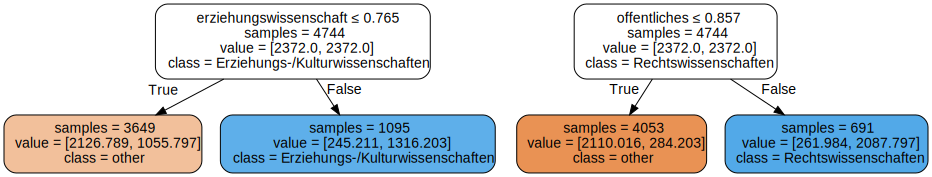

<span style="font-size:11pt"><br><br></span>

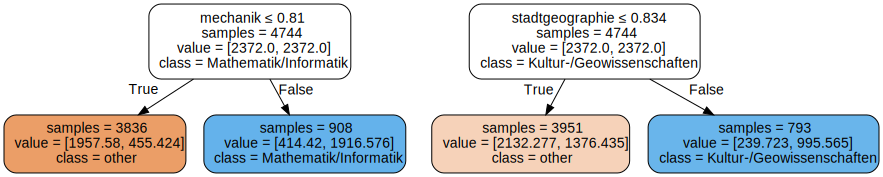

<span style="font-size:11pt"><br><br></span>

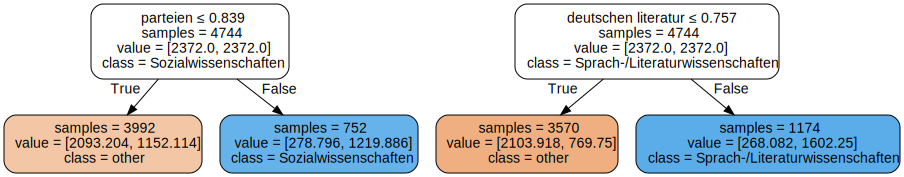

<span style="font-size:11pt"><br><br></span>

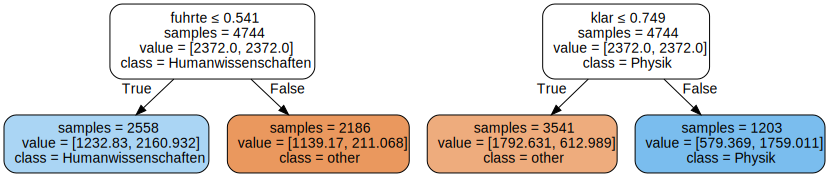

<span style="font-size:11pt"><br><br></span>

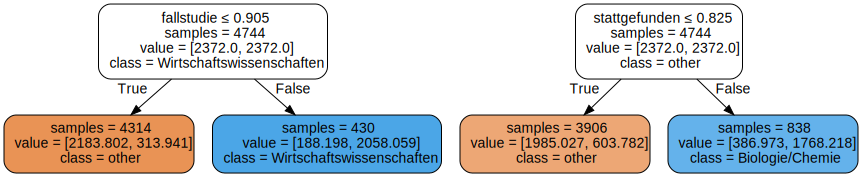

<span style="font-size:11pt"><br><br></span>

<span style="font-size:11pt">Per-Class-Scores: Erziehungs-/Kulturwissenschaften: 0.79, Rechtswissenschaften: 0.90, Mathematik/Informatik: 0.82, Kultur-/Geowissenschaften: 0.81, Sozialwissenschaften: 0.84, Sprach-/Literaturwissenschaften: 0.84, Humanwissenschaften: 0.49, Physik: 0.76, Wirtschaftswissenschaften: 0.91, Biologie/Chemie: 0.83</span>

<span style="font-size:11pt">Unweighted Mean acc: 79.88%</span>

<span style="font-size:11pt">Weighted Mean acc: 80.21%</span>

In [389]:
clfs = classify_shallowtree(clusters, embedding, descriptions, ctx.obj["dataset_class"], one_vs_rest=True, dt_depth=1, test_percentage_crossval=0.33,
                       classes="fachbereich", cluster_reprs=cluster_reprs, verbose=False, return_features=True, balance_classes=True, do_plot=True)[0]

### Sample two (best before 05.03.2022, keep me!)

<span style="font-size:11pt">Using classes from fachbereich - 7319/11942 entities have a class</span>

<span style="font-size:11pt">Labels (10 classes): <span style="color: #0000ff">Sprach-/Literaturwissenschaften</span>: 1723, <span style="color: #0000ff">Erziehungs-/Kulturwissenschaften</span>: 2090, <span style="color: #0000ff">Kultur-/Geowissenschaften</span>: 1457, <span style="color: #0000ff">Sozialwissenschaften</span>: 707, <span style="color: #0000ff">Rechtswissenschaften</span>: 350, <span style="color: #0000ff">Humanwissenschaften</span>: 376, <span style="color: #0000ff">Biologie/Chemie</span>: 167, <span style="color: #0000ff">Mathematik/Informatik</span>: 197, <span style="color: #0000ff">Physik</span>: 147, <span style="color: #0000ff">Wirtschaftswissenschaften</span>: 105</span>

<span style="font-size:11pt">Eval-Settings: type: <span style="color: #0000ff">one-vs-rest</span>, DT-Depth: <span style="color: #0000ff">1</span>, train-test-split:<span style="color: #0000ff"> 33.0% in test-set </span></span>

Some nodes will be renamed.
Some nodes will be renamed.
Some nodes will be renamed.
Some nodes will be renamed.
Some nodes will be renamed.


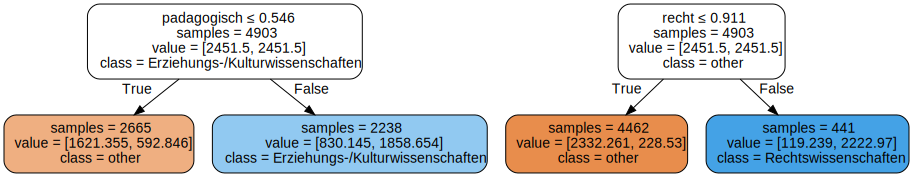

<span style="font-size:11pt"><br><br></span>

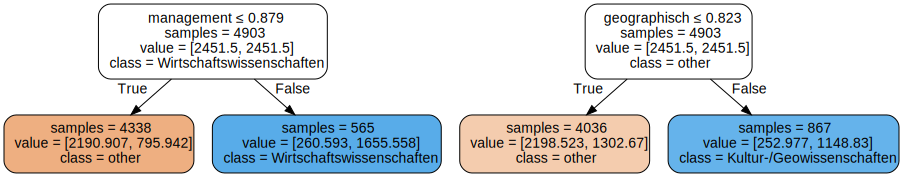

<span style="font-size:11pt"><br><br></span>

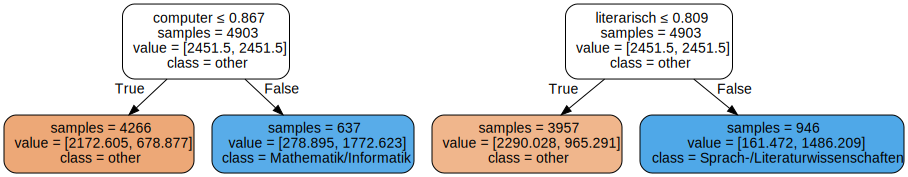

<span style="font-size:11pt"><br><br></span>

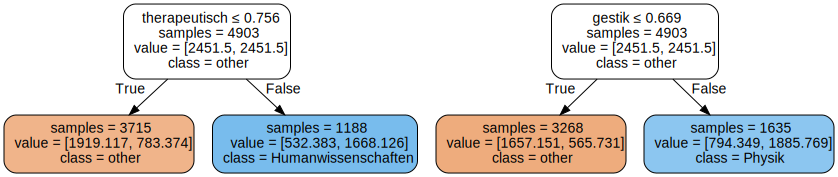

<span style="font-size:11pt"><br><br></span>

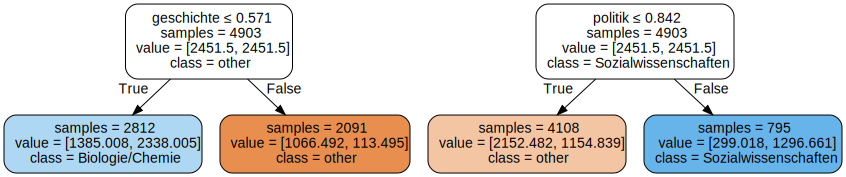

<span style="font-size:11pt"><br><br></span>

<span style="font-size:11pt">Per-Class-Scores: Erziehungs-/Kulturwissenschaften: 0.68, Rechtswissenschaften: 0.95, Wirtschaftswissenschaften: 0.88, Kultur-/Geowissenschaften: 0.81, Mathematik/Informatik: 0.87, Sprach-/Literaturwissenschaften: 0.86, Humanwissenschaften: 0.77, Physik: 0.68, Biologie/Chemie: 0.46, Sozialwissenschaften: 0.86</span>

<span style="font-size:11pt">Unweighted Mean Accuracy: 78.17%</span>

<span style="font-size:11pt">Weighted Mean Accuracy: 78.50%</span>

In [18]:
# res = classify_shallowtree_multi(clusters, embedding, descriptions, ctx.obj["dataset_class"], verbose=True)
res = classify_shallowtree(clusters, embedding, descriptions, ctx.obj["dataset_class"], one_vs_rest=True, dt_depth=1, test_percentage_crossval=0.33, 
                           classes="fachbereich", cluster_reprs=cluster_reprs, verbose=False, return_features=False, balance_classes=True, do_plot=True)

<br><br><br><br><br><br><br><br>

# Classifying DDC

<span style="font-size:11pt">Using classes from ddc_l1 - 5199/11942 entities have a class</span>

<span style="font-size:11pt">Labels (10 classes): <span style="color: #0000ff">Social sciences</span>: 1986, <span style="color: #0000ff">History and geography</span>: 225, <span style="color: #0000ff">Pure Science</span>: 265, <span style="color: #0000ff">Literature</span>: 362, <span style="color: #0000ff">Arts and recreation</span>: 424, <span style="color: #0000ff">Technology</span>: 672, <span style="color: #0000ff">Religion</span>: 235, <span style="color: #0000ff">Computer science, information, general</span>: 319, <span style="color: #0000ff">Language</span>: 452, <span style="color: #0000ff">Philosophy and psychology</span>: 259</span>

<span style="font-size:11pt">Eval-Settings: type: <span style="color: #0000ff">one-vs-rest</span>, DT-Depth: <span style="color: #0000ff">1</span>, train-test-split:<span style="color: #0000ff"> 33.0% in test-set </span></span>

Some nodes will be renamed.
Some nodes will be renamed.
Some nodes will be renamed.
Some nodes will be renamed.
Some nodes will be renamed.


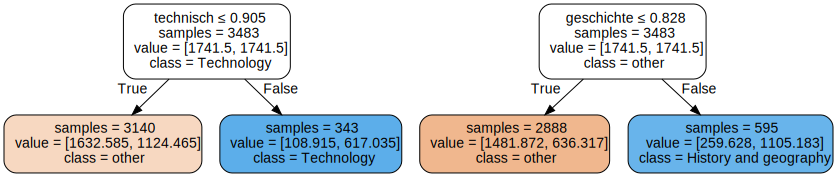

<span style="font-size:11pt"><br><br></span>

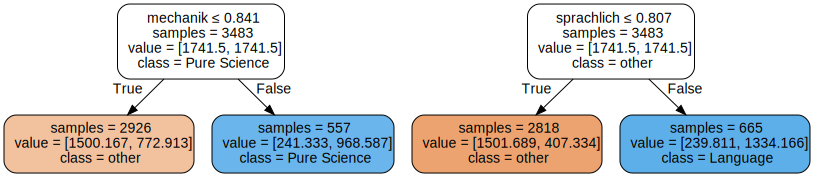

<span style="font-size:11pt"><br><br></span>

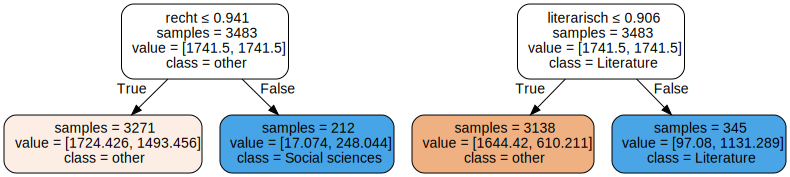

<span style="font-size:11pt"><br><br></span>

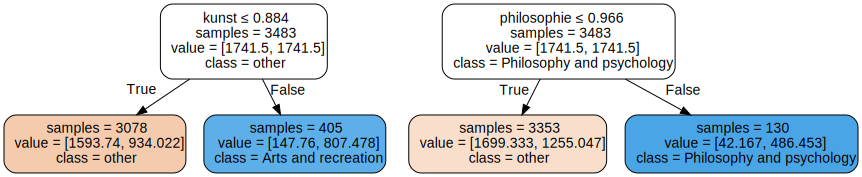

<span style="font-size:11pt"><br><br></span>

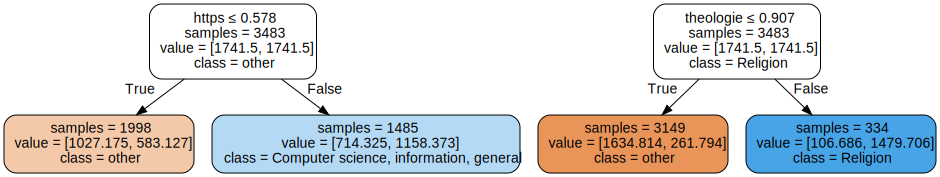

<span style="font-size:11pt"><br><br></span>

<span style="font-size:11pt">Per-Class-Scores: Technology: 0.84, History and geography: 0.84, Pure Science: 0.85, Language: 0.84, Social sciences: 0.67, Literature: 0.92, Arts and recreation: 0.88, Philosophy and psychology: 0.95, Computer science, information, general: 0.61, Religion: 0.94</span>

<span style="font-size:11pt">Unweighted Mean Accuracy: 83.40%</span>

<span style="font-size:11pt">Weighted Mean Accuracy: 78.04%</span>

In [20]:
res = classify_shallowtree(clusters, embedding, descriptions, ctx.obj["dataset_class"], one_vs_rest=True, dt_depth=1, test_percentage_crossval=0.33, 
                           classes="ddc_l1", cluster_reprs=cluster_reprs, verbose=False, return_features=False, balance_classes=True, do_plot=True)

## Another one, cause the other also looked good

<span style="font-size:11pt">Running with the following settings [<span style="color: #ff00ff">e2a70a9bf2</span>]: CLASSIFIER: <span style="color: #0000ff">SVM</span>, CLASSIFIER_SUCCMETRIC: <span style="color: #ff0000">kappa_digitized_onlypos_2</span>, CLUSTER_DIRECTION_ALGO: <span style="color: #0000ff">reclassify</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #0000ff">count</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">200</span>, EXTRACTION_METHOD: <span style="color: #ff0000">tfidf</span>, KAPPA_WEIGHTS: <span style="color: #0000ff">quadratic</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhtcsldp</span>, PRIM_LAMBDA: <span style="color: #0000ff">0.5</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">tfidf</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, SEC_LAMBDA: <span style="color: #ff0000">0.2</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

<span style="font-size:11pt">Using classes from ddc_l1 - 5199/11942 entities have a class</span>

<span style="font-size:11pt">Labels (10 classes): <span style="color: #0000ff">Social sciences</span>: 1986, <span style="color: #0000ff">History and geography</span>: 225, <span style="color: #0000ff">Pure Science</span>: 265, <span style="color: #0000ff">Literature</span>: 362, <span style="color: #0000ff">Arts and recreation</span>: 424, <span style="color: #0000ff">Technology</span>: 672, <span style="color: #0000ff">Religion</span>: 235, <span style="color: #0000ff">Computer science, information, general</span>: 319, <span style="color: #0000ff">Language</span>: 452, <span style="color: #0000ff">Philosophy and psychology</span>: 259</span>

<span style="font-size:11pt">Eval-Settings: type: <span style="color: #0000ff">one-vs-rest</span>, DT-Depth: <span style="color: #0000ff">1</span>, train-test-split:<span style="color: #0000ff"> 33.0% in test-set </span></span>

Some nodes will be renamed.
Some nodes will be renamed.
Some nodes will be renamed.
Some nodes will be renamed.
Some nodes will be renamed.


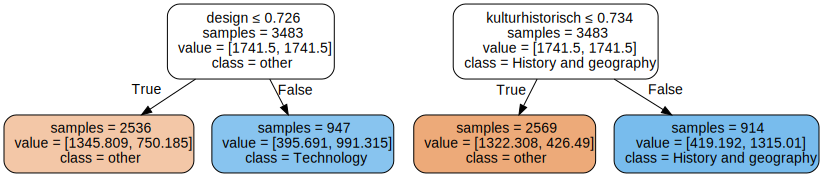

<span style="font-size:11pt"><br><br></span>

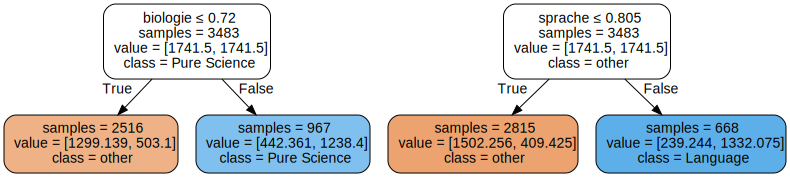

<span style="font-size:11pt"><br><br></span>

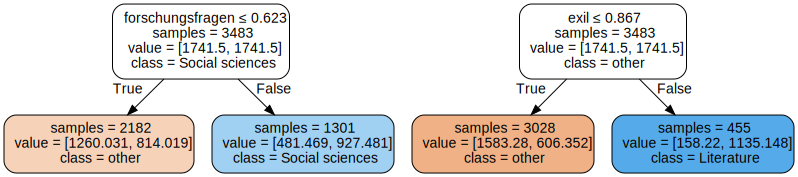

<span style="font-size:11pt"><br><br></span>

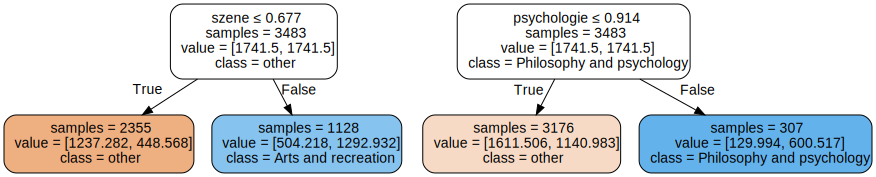

<span style="font-size:11pt"><br><br></span>

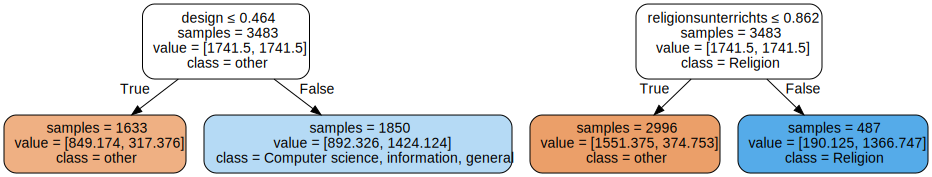

<span style="font-size:11pt"><br><br></span>

<span style="font-size:11pt">Per-Class-Scores: Technology: 0.73, History and geography: 0.74, Pure Science: 0.73, Language: 0.86, Social sciences: 0.64, Literature: 0.88, Arts and recreation: 0.71, Philosophy and psychology: 0.90, Computer science, information, general: 0.48, Religion: 0.89</span>

<span style="font-size:11pt">Unweighted Mean Accuracy: 75.62%</span>

<span style="font-size:11pt">Weighted Mean Accuracy: 71.73%</span>

In [22]:
conf = {'dataset': 'siddata2022', 'debug': False, 'kappa_weights': 'quadratic', 'embed_dimensions': 200, 'embed_algo': 'mds', 'quantification_measure': 'tfidf', 'dcm_quant_measure': 'count', 'extraction_method': 'tfidf', 'translate_policy': 'onlyorig', 'pp_components': 'mfauhtcsldp', 'language': 'de', 'min_words_per_desc': 80, 'prim_lambda': 0.5, 'sec_lambda': 0.2, 'classifier_succmetric': 'kappa_digitized_onlypos_2', 'cluster_direction_algo': 'reclassify'}
ctx = SnakeContext.loader_context(config=conf, silent=True)
ctx.print_important_settings()
clusters, embedding, descriptions = ctx.load("clusters", "embedding", "pp_descriptions")

res = classify_shallowtree(clusters, embedding, descriptions, ctx.obj["dataset_class"], one_vs_rest=True, dt_depth=1, test_percentage_crossval=0.33,
                           classes="ddc_l1", verbose=False, return_features=False, balance_classes=True, do_plot=True)

# Analyze Misclassifications

## For one-vs-rest

In [11]:
clfs = classify_shallowtree(clusters, embedding, descriptions, ctx.obj["dataset_class"], one_vs_rest=True, dt_depth=None, test_percentage_crossval=0.33, classes="fachbereich", cluster_reprs=cluster_reprs, verbose=False, return_features=True, balance_classes=True, do_plot=False)

<span style="font-size:11pt">Using classes from fachbereich - 7081/11601 entities have a class</span>

<span style="font-size:11pt">Labels (10 classes): <span style="color: #0000ff">Sprach-/Literaturwissenschaften</span>: 1656, <span style="color: #0000ff">Erziehungs-/Kulturwissenschaften</span>: 2023, <span style="color: #0000ff">Kultur-/Geowissenschaften</span>: 1431, <span style="color: #0000ff">Sozialwissenschaften</span>: 704, <span style="color: #0000ff">Rechtswissenschaften</span>: 334, <span style="color: #0000ff">Humanwissenschaften</span>: 345, <span style="color: #0000ff">Biologie/Chemie</span>: 159, <span style="color: #0000ff">Mathematik/Informatik</span>: 185, <span style="color: #0000ff">Physik</span>: 137, <span style="color: #0000ff">Wirtschaftswissenschaften</span>: 107</span>

<span style="font-size:11pt">Eval-Settings: metric: <span style="color: #0000ff">acc</span>, type: <span style="color: #0000ff">one-vs-rest</span>, DT-Depth: <span style="color: #0000ff">None</span>, train-test-split:<span style="color: #0000ff"> 33.0% in test-set </span></span>

<span style="font-size:11pt">Per-Class-Scores: Humanwissenschaften: 0.94, Sprach-/Literaturwissenschaften: 0.90, Mathematik/Informatik: 0.97, Erziehungs-/Kulturwissenschaften: 0.85, Sozialwissenschaften: 0.90, Wirtschaftswissenschaften: 0.98, Biologie/Chemie: 0.98, Kultur-/Geowissenschaften: 0.87, Rechtswissenschaften: 0.98, Physik: 0.98</span>

<span style="font-size:11pt">Unweighted Mean acc: 93.53%</span>

<span style="font-size:11pt">Weighted Mean acc: 89.10%</span>

In [99]:
accs = [(clfs[0][i].predict(clfs[1].values) == clfs[2][i]).mean() for i in range(len(clfs[0]))]
sum(accs)/len(accs)

0.7914136421409406

In [100]:
corrects = np.array([clfs[0][i].predict(clfs[1].values) == clfs[2][i] for i in range(len(clfs[0]))])
misclassified = np.where(corrects.sum(axis=0) < corrects.shape[0])[0]
len(misclassified)
[descriptions._descriptions[i] for i in misclassified][:10]

[Description(de: '"... and miles to go before I sleep".  "But I have promises to keep, and miles to go before I sleep” - [...]'),
 Description(de: '"...herrlicher als die Werke der alten Römer". Bronzewerke des Mittelalters und der Frühen Neuzeit.  Die Bronzetüren Karls des Großen in Aachen, der Braunschweiger [...]'),
 Description(de: '"Alt ist der, der aufhört neugierig zu sein" (Irisches Sprichwort) Perspektiven und Entwicklung im Beruf ab dem 50. Lebensjahr.  Sie haben einen großen beruflichen Erfahrungsschatz und erprobte [...]'),
 Description(de: '"Auswandern nach Amerika!" Von der Quelle zur Ausstellung.  Zwischen 1815 und 1914 verließen 5,5 Millionen Deutsche den [...]'),
 Description(de: '"Balu und Du" - Präventionsprojekt für benachteiligte Kinder.  Wenn Sie sich vorstellen können, für ein Kind, das in einer [...]'),
 Description(de: '"Balu und Du" - ein Präventionsprojekt für Kinder.  Wenn Sie sich vorstellen können, für ein Kind, das in einer [...]'),
 Description(de: '"Bal

## For all-at-once

In [101]:
clfs = classify_shallowtree(clusters, embedding, descriptions, ctx.obj["dataset_class"], one_vs_rest=False, dt_depth=15, test_percentage_crossval=0.33, classes="fachbereich", cluster_reprs=cluster_reprs, verbose=False, return_features=True, balance_classes=True, do_plot=False)

<span style="font-size:11pt">Using classes from fachbereich - 7081/11601 entities have a class</span>

<span style="font-size:11pt">Labels (10 classes): <span style="color: #0000ff">Sprach-/Literaturwissenschaften</span>: 1656, <span style="color: #0000ff">Erziehungs-/Kulturwissenschaften</span>: 2023, <span style="color: #0000ff">Kultur-/Geowissenschaften</span>: 1431, <span style="color: #0000ff">Sozialwissenschaften</span>: 704, <span style="color: #0000ff">Rechtswissenschaften</span>: 334, <span style="color: #0000ff">Humanwissenschaften</span>: 345, <span style="color: #0000ff">Biologie/Chemie</span>: 159, <span style="color: #0000ff">Mathematik/Informatik</span>: 185, <span style="color: #0000ff">Physik</span>: 137, <span style="color: #0000ff">Wirtschaftswissenschaften</span>: 107</span>

<span style="font-size:11pt">Eval-Settings: metric: <span style="color: #0000ff">acc</span>, type: <span style="color: #0000ff">all-at-once</span>, DT-Depth: <span style="color: #0000ff">15</span>, train-test-split:<span style="color: #0000ff"> 33.0% in test-set </span></span>

<span style="font-size:11pt">acc: 0.57</span>

In [102]:
wrongs = np.where(~(clfs[0][0].predict(clfs[1].values) == clfs[2]))[1]
len(wrongs)
[descriptions._descriptions[i] for i in wrongs][:10]

[Description(de: '!! FÄLLT AUS !! Phonetik des Deutschen.  Phonetik beschäftigt sich mit gesprochener Sprache. Was passiert [...]'),
 Description(de: '"... and miles to go before I sleep".  "But I have promises to keep, and miles to go before I sleep” - [...]'),
 Description(de: '"... auferstanden von den Toten"? Die Debatten um die historische Wahrheit, religiöse Bedeutung und dogmatische Interpretation der sogenannten Auferstehung Jesu in der protestantischen Theologie der Neuzeit.  „Er ist auferstanden. Er ist wahrhaftig auferstanden!“. Der [...]'),
 Description(de: '"...herrlicher als die Werke der alten Römer". Bronzewerke des Mittelalters und der Frühen Neuzeit.  Die Bronzetüren Karls des Großen in Aachen, der Braunschweiger [...]'),
 Description(de: '"...und dein Fremder in deinen Toren." (Ex 20,10) - Christlich-ethische Zugänge zum Thema Flucht und Migration..  Die Themen Migration und Flucht sind in den vergangenen Jahren [...]'),
 Description(de: '"Auf den Anfang kommt es an.

<br><br>
**...unfortunately not showing that only descriptions like "Tutors: xyz" are misclassified**